# Анализ решений по апелляциям на постановления ГИБДД
## п.3 Exploratory Data Analysis

Цель данного этапа - EDA решений по обжалованиям:  
1) Построение распредений в абсолютном и процентном соотношении удовлетворений/отказов по жалобам по разным статьям КоАП, судам, судьями другим факторам.  
2) Построение динамики процента удовлетворений во времени с учётом различных факторов (статьи, суды).  
3) Поиск факторов, влияющих на удовлетворение жалоб по каждой статье (или кластеру статей).  
4) Выявление закономерностей между результатом решения и призаками решения.  

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#load from csv back
df_gibdd = pd.read_csv('df_gibdd.csv')
df_gibdd.head()

,region,court,judge,vidpr,etapd,category,result,date,vid_dokumenta,file,...,video,DTP,registrator,svidetel,ponyatoy,passazhir,peshekhod,poterpevshiy,judgments_type,judgment_termination
0,Москва,Басманный районный суд (Город Москва),Карпов Артур Геннадьевич,Административное,Апелляция,12.16 ч.1,Оставлено без изменения,06.11.2012,решение,../../data/sou/basmannyj-rajonnyj-sud-gorod-mo...,...,видео,True,False,True,False,False,False,False,Постановление по делу об АП,False
1,Москва,Басманный районный суд (Город Москва),Дударь Н. Н.,Административное,Апелляция,12.14 ч.3,Оставлено без изменения,05.07.2012,решение,../../data/sou/basmannyj-rajonnyj-sud-gorod-mo...,...,Нет,True,False,False,False,False,False,False,Постановление по делу об АП,False
2,Москва,Басманный районный суд (Город Москва),Дударь Н. Н.,Административное,Апелляция,12.14 ч.3,Оставлено без изменения,05.07.2012,решение,../../data/sou/basmannyj-rajonnyj-sud-gorod-mo...,...,Нет,True,False,True,False,True,False,False,Постановление по делу об АП,False
3,Москва,Басманный районный суд (Город Москва),Дударь Наталия Николаевна,Административное,Апелляция,12.14 ч.3,Оставлено без изменения,13.09.2012,решение,../../data/sou/basmannyj-rajonnyj-sud-gorod-mo...,...,Нет,True,False,False,False,False,False,False,Постановление по делу об АП,False
4,Москва,Басманный районный суд (Город Москва),Скуридина Ирина Анатольевна,Административное,Апелляция,12.16 ч.5,Оставлено без изменения,07.03.2013,решение,../../data/sou/basmannyj-rajonnyj-sud-gorod-mo...,...,Нет,False,False,False,False,False,False,False,Постановление по делу об АП,False


## 1. Построение распределений значений признаков и целевой переменной

### 1.1 Общее распределение значений целевой переменной

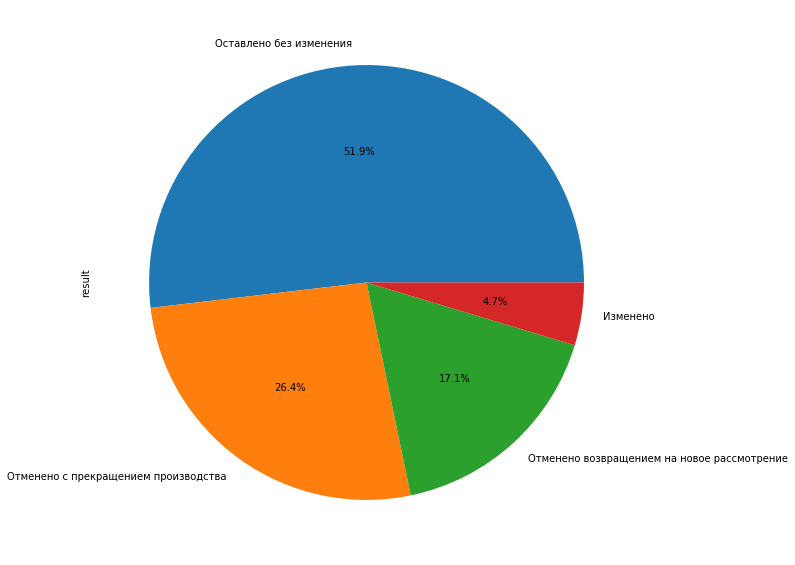

In [3]:
df_gibdd['result'].value_counts().plot.pie(figsize=(10,10), autopct='%1.1f%%')

### 1.2 Общее распредеделение значений признаков и долевое распределение значений целевой переменной в зависимости от значений признаков

Задача:
1. Построить количественное распределение объектов по каждому признаку
2. Построить соотношение значений целевой переменной по каждому признаку

In [4]:
#Сформируем спикок признаков, принимающих от 2 до 50 уникальных значений, по которым будем смотреть распределение
features_to_plot = []
for column in df_gibdd.drop('result', axis=1).columns:
    if (len(df_gibdd[column].unique()) > 1)&(len(df_gibdd[column].unique()) < 50):
        features_to_plot.append(column)
features_to_plot

['court',
 'category',
 'representative',
 'photo',
 'video',
 'DTP',
 'registrator',
 'svidetel',
 'ponyatoy',
 'passazhir',
 'peshekhod',
 'poterpevshiy',
 'judgments_type',
 'judgment_termination']

In [5]:
#creating the colormap
from matplotlib.colors import LinearSegmentedColormap
colors = ['r', 'y', 'c', 'g']  # R -> Y -> C -> G
# Create the colormap
cm = LinearSegmentedColormap.from_list('RYCG', colors)

In [6]:
def plot_cat_distr(df_gibdd, feature, target='result', title=None, general=True, min_n_objs=1, cm=cm):
    plt.rcParams.update({'figure.max_open_warning': 0})
    if feature!=target:
        #define figsize by feature uniques
        if len(df_gibdd[feature].unique()) == 1:
            figsize_general = (15, len(df_gibdd[feature].unique())*2)
        elif len(df_gibdd[feature].unique()) < 3:
            figsize_general = (15, len(df_gibdd[feature].unique()))
        elif len(df_gibdd[feature].unique()) < 5:
            figsize_general = (15, len(df_gibdd[feature].unique())/2)
        else: figsize_general = (15, len(df_gibdd[feature].unique())/4)
        figsize=figsize_general #если min_n_objs=1 figsize такой же как figsize_general

        #make data_sum_feature
        data_sum_feat = df_gibdd.groupby([feature]).count().reset_index()
        data_sum_feat['sum_'+feature] = data_sum_feat[target]
        data_sum_feat = data_sum_feat[[feature, 'sum_'+feature]]
        #data_sum_courts

        #make data to plot
        cols_order = ['Оставлено без изменения', 'Изменено', 'Отменено возвращением на новое рассмотрение', 
                      'Отменено с прекращением производства']
        data = df_gibdd.pivot_table(columns=target, index = feature, values = 'region', fill_value=0, aggfunc='count')
        #add 'zero'-columns in some target_values is not exist
        if not set(cols_order).issubset(data.columns):
            for col in cols_order:
                if col not in data.columns:
                    data[col]=[0]*len(data)
        #set columns order            
        data = data[cols_order]
        #divide on feature sum to get percents
        data = data.div(data_sum_feat['sum_'+feature].values, axis=0).sort_values(['Оставлено без изменения', 
            'Отменено с прекращением производства', 'Отменено возвращением на новое рассмотрение'], ascending=[False, 
                                                                                                               True, True])
        
        #filter feature_values that contain less than min_n_objs objects
        if min_n_objs > 1:
            feature_value_list = df_gibdd[feature].value_counts()
            feature_value_list = feature_value_list[feature_value_list>=min_n_objs]
            data = data[data.index.isin(feature_value_list.index)]
            #переопределение figsize если min_n_objs>1
            if len(feature_value_list) == 1:
                figsize = (15, len(feature_value_list)*2)
            elif len(feature_value_list) < 3:
                figsize = (15, len(feature_value_list))
            elif len(feature_value_list) < 5:
                figsize = (15, len(feature_value_list)/2)
            else: figsize = (15, len(feature_value_list)/4)
            if title==None: title=''
            #title = title+' (only '+feature+' that contains more than '+str(min_n_objs)+' objects)'
        
        #plot 1)feature in general, 2)share of feature by target
        if general:
            pd.DataFrame(df_gibdd[feature].value_counts()).sort_values(feature).plot.barh(figsize=figsize_general, 
                title='Feature: '+feature+title+' (total amount)', legend=False)        
        if len(data)==0: print(title+' - contains less than {} objects'.format(min_n_objs))
        else:    
            if min_n_objs > 1:
                title = title+' (only '+feature+' that contains more than '+str(min_n_objs)+' objects)'
            data.plot.barh(stacked=True, figsize=figsize, title='Feature: '+feature+title+' (target distribution)', 
                           colormap=cm)

CPU times: user 1.38 s, sys: 0 ns, total: 1.38 s
Wall time: 1.37 s


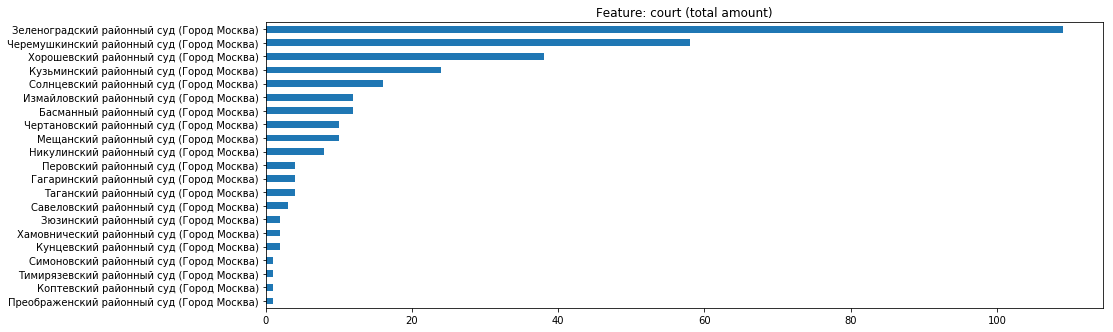

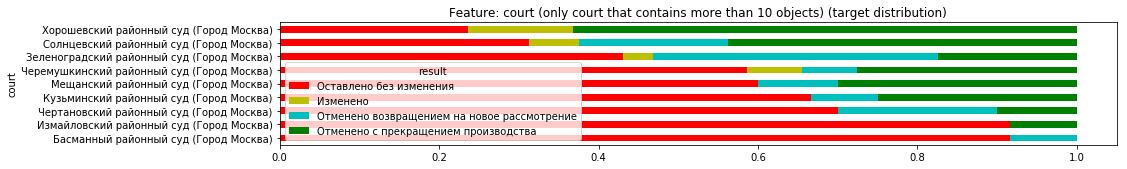

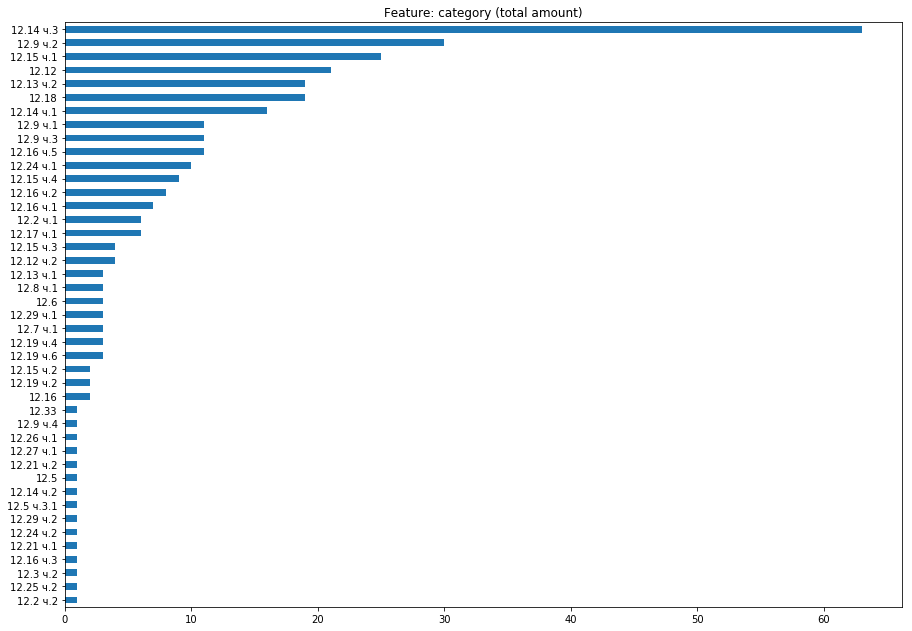

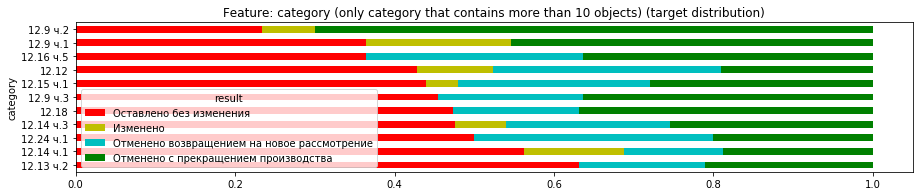

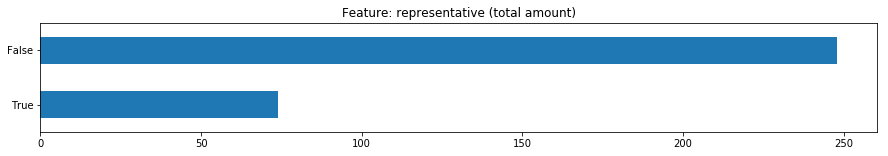

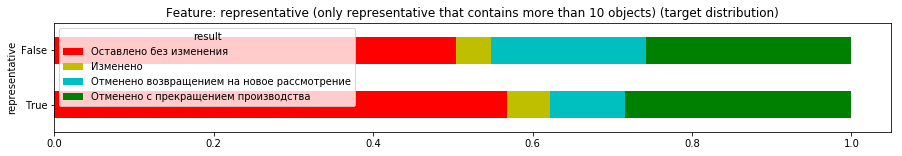

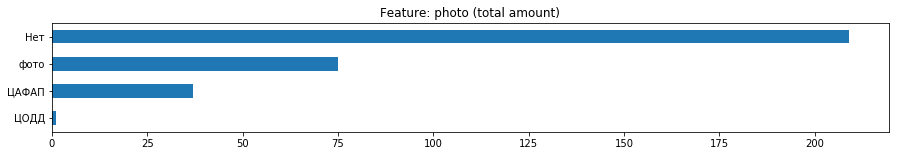

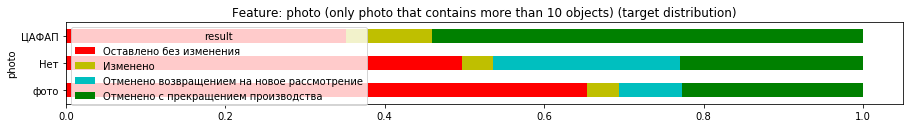

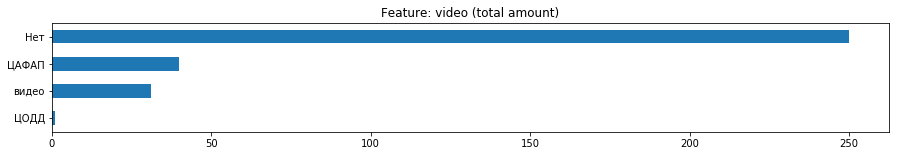

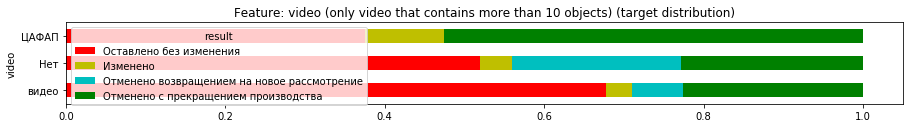

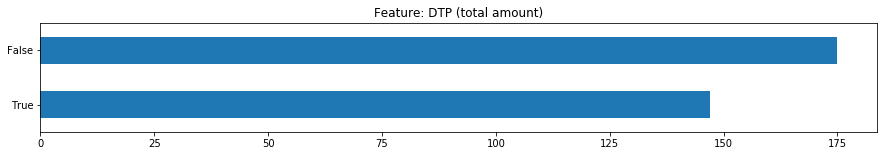

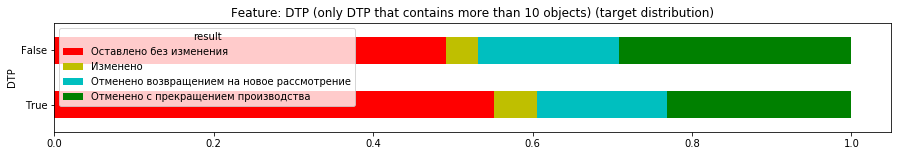

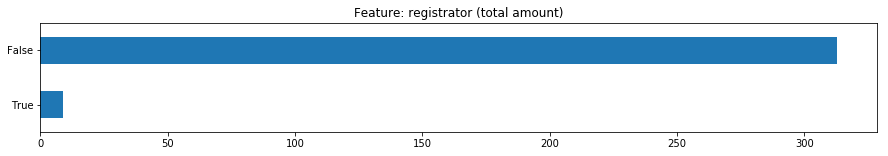

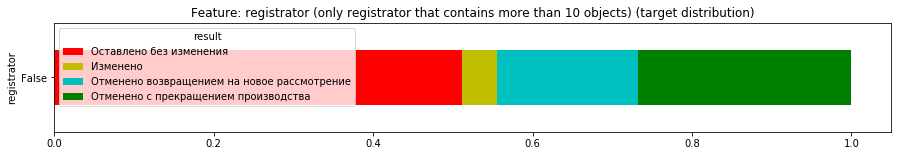

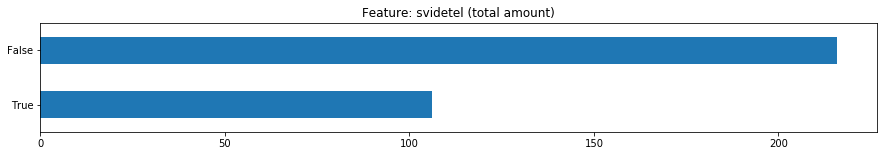

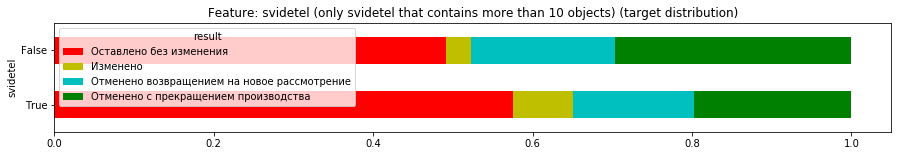

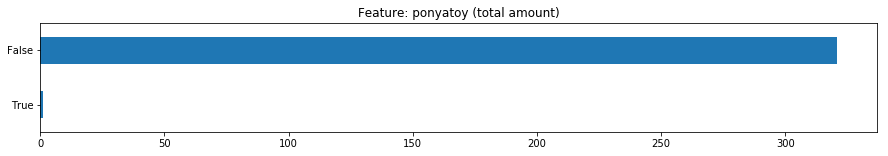

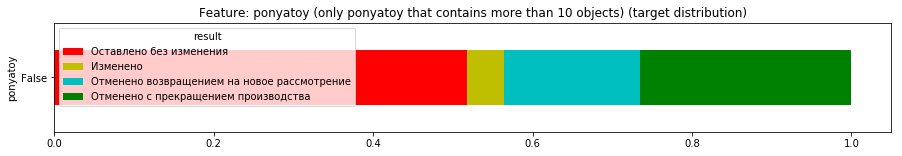

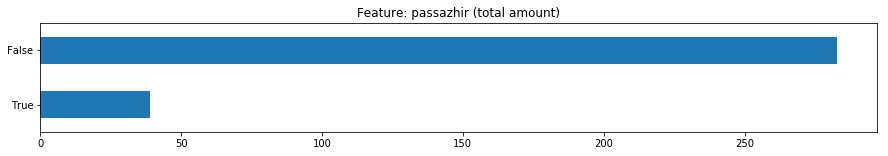

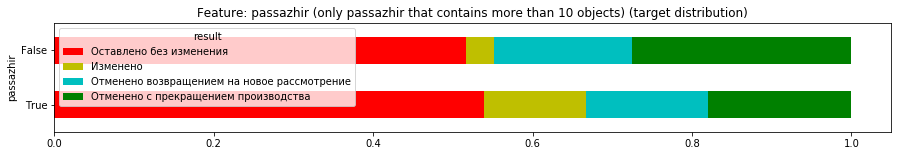

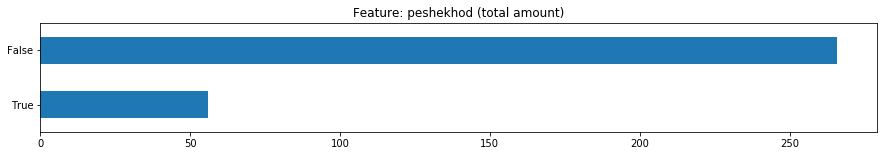

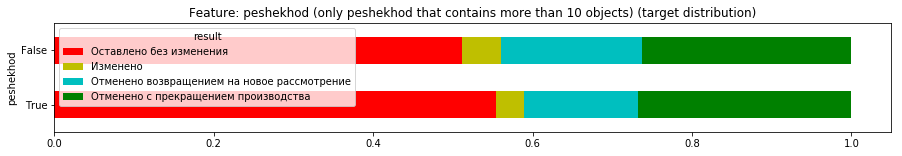

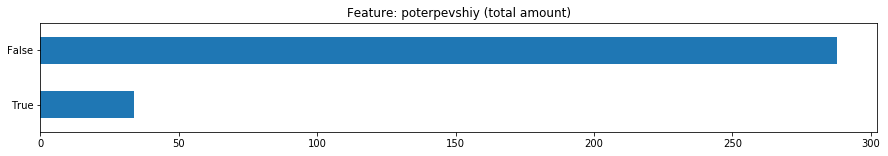

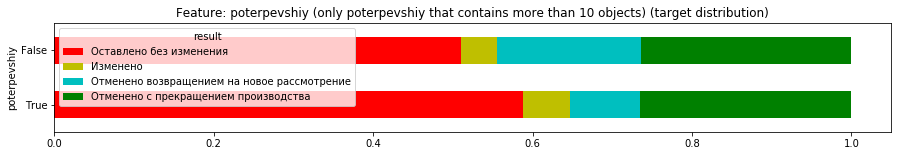

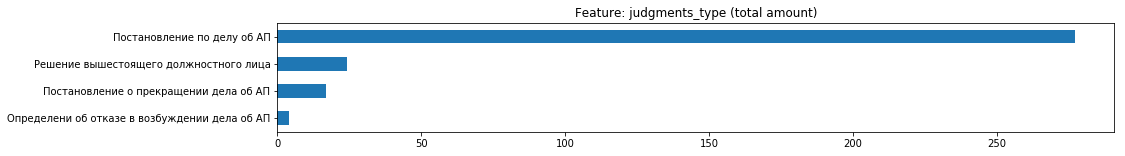

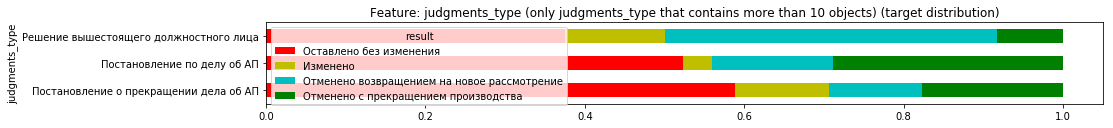

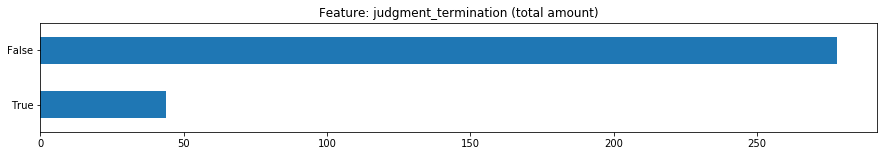

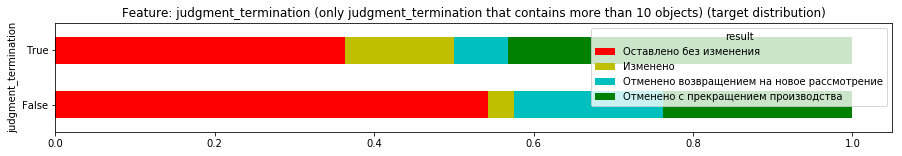

In [7]:
%%time
for feature in features_to_plot:    
    plot_cat_distr(df_gibdd, feature, target='result', min_n_objs=10, cm=cm)

### 1.3 Влияние различных факторов дела, на распределние целевой переменной по разным статьям

#### 1.3.1 Распределение количества объектов (решений) и соотношения значений целевой переменной по значениям признака 'category' (статья) в зависимости от значений различных факторов.

Цель: проверить если ли похожие между собой статьи, в которых одинаково или сильно похоже соотношение значений целевой пеменной в зависимости от значений факторов, при наличии проверть возможность класстеризации для уменьшения уникальных значений переменной 'category'.

Задача: вывести распределение 1) количества объектов и 2) долей целевой переменной для каждого значения каждого фактора по кажой статье.   
Вторая часть задачи должна быть реализована в следующем виде:
1. Один barh plot для каждого уникального значения фактора (например representative=False, DTP=True,...)
2. В barh plot каждый bar соотствует одному значению признака 'category', которые существуют для заданного значения фактора
3. В каждом barh - распределению долей значенний целевой переменной (result)

Реализация:
1. Фильтруем DF по значению фактора
2. Аггрегируем data для barh plot
3. Строим barh plot в цикле для каждого фактора и заранее заданной feature (здесь только для 'category')

. Factor: photo = ЦОДД - contains less than 5 objects
. Factor: video = ЦОДД - contains less than 5 objects
. Factor: registrator = True - contains less than 5 objects
. Factor: ponyatoy = True - contains less than 5 objects
. Factor: judgments_type = Определени об отказе в возбуждении дела об АП - contains less than 5 objects
CPU times: user 3.92 s, sys: 48 ms, total: 3.96 s
Wall time: 3.91 s


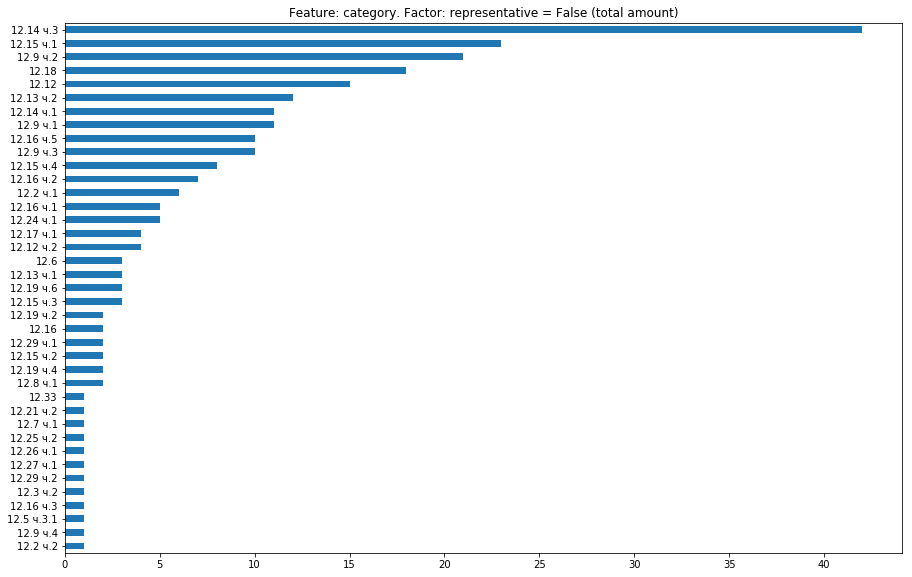

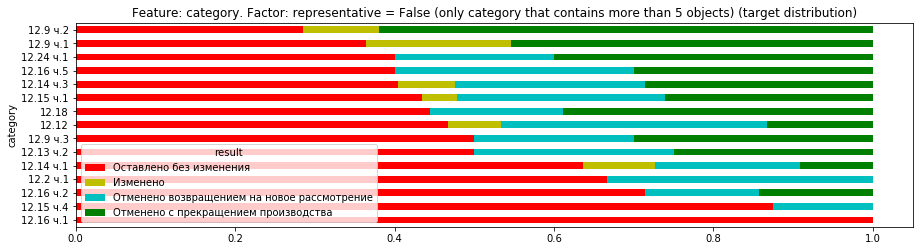

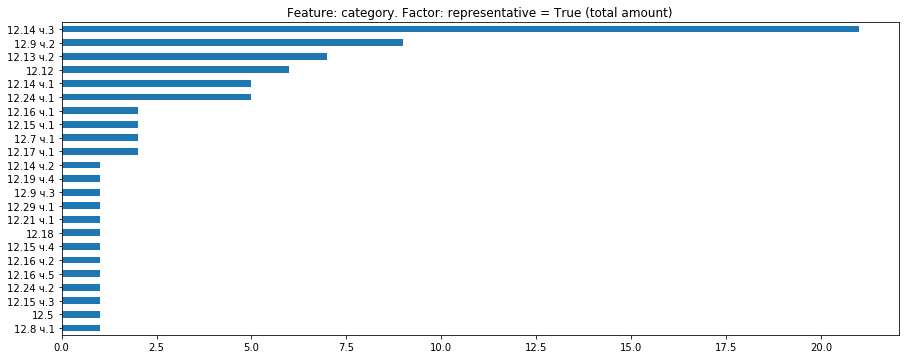

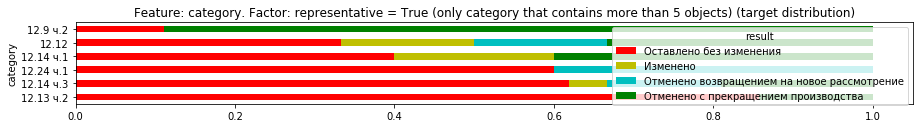

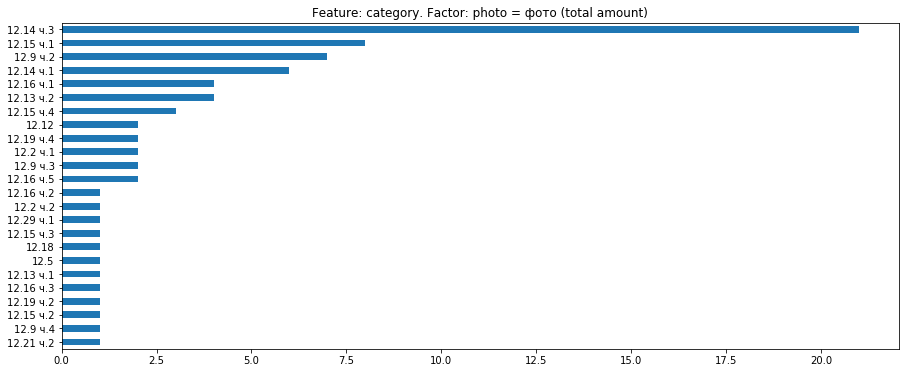

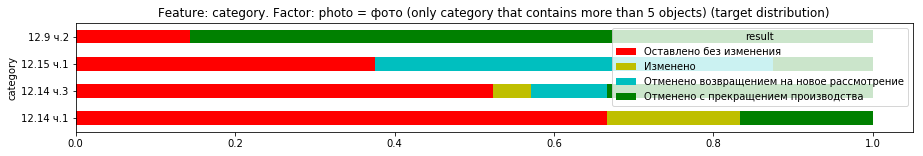

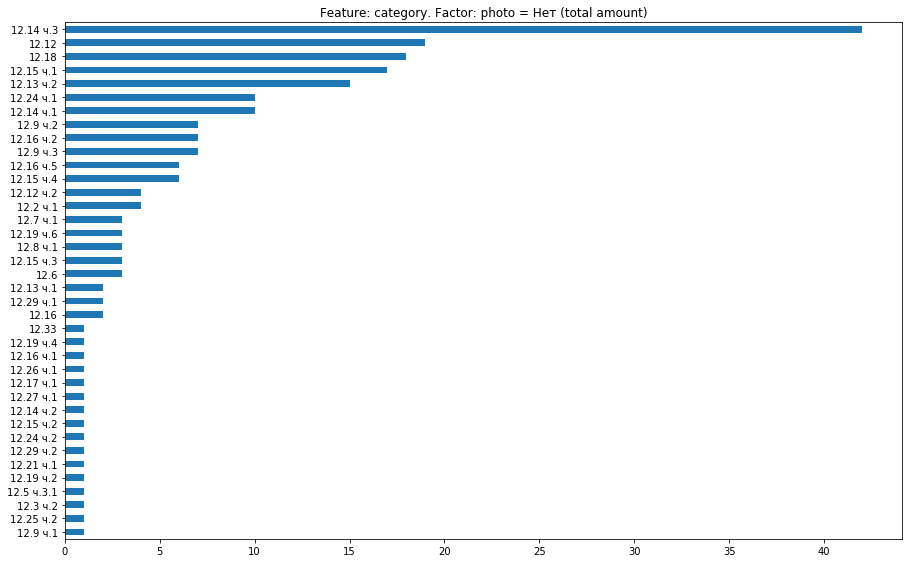

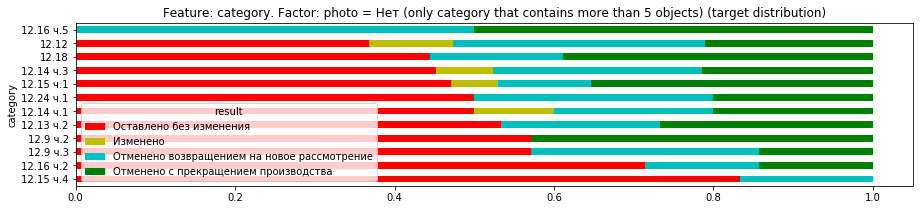

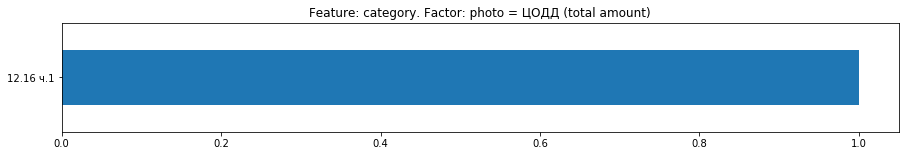

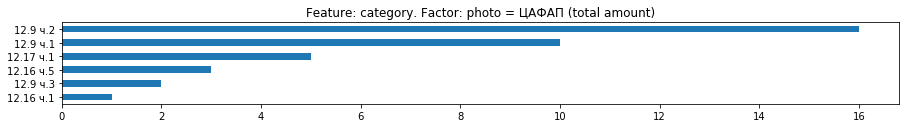

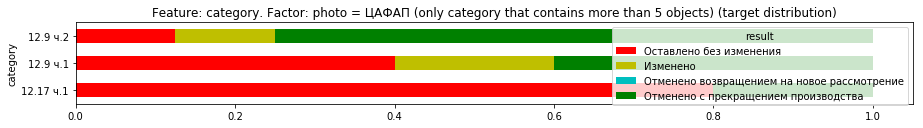

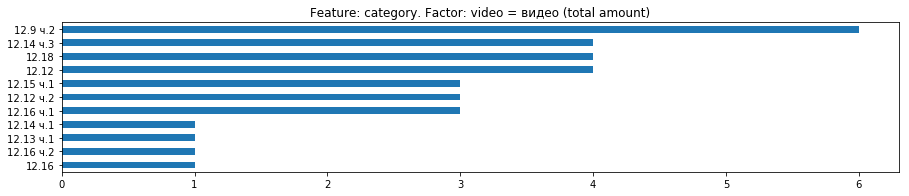

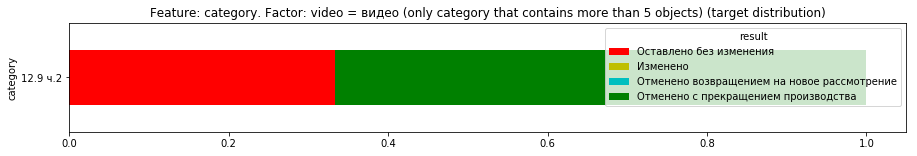

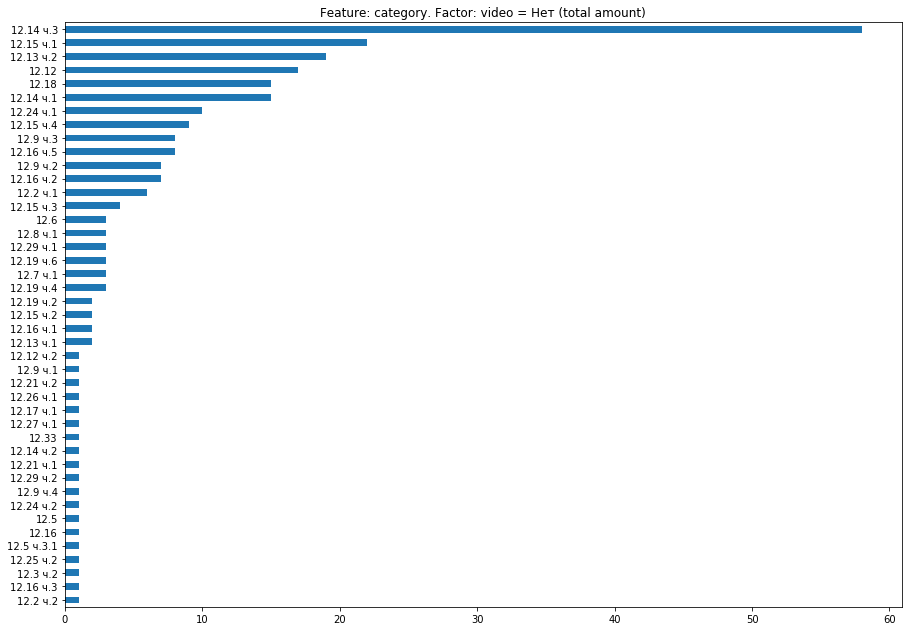

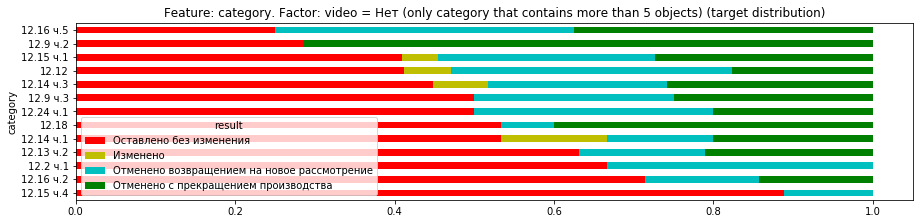

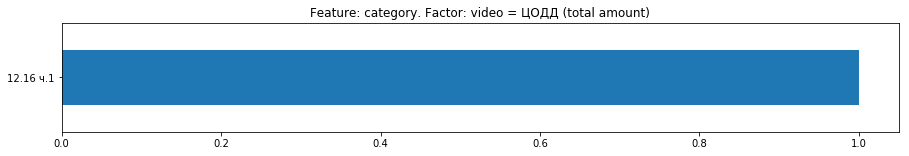

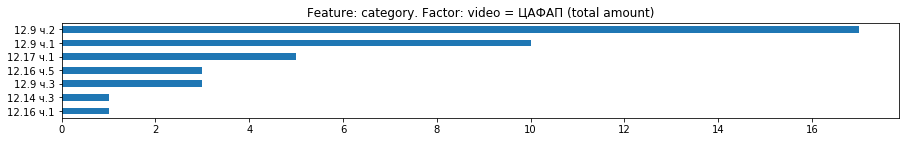

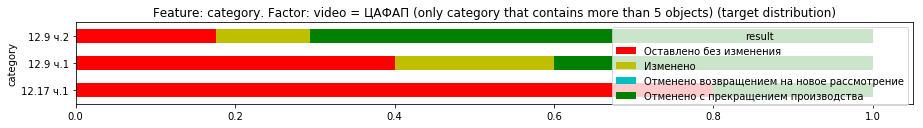

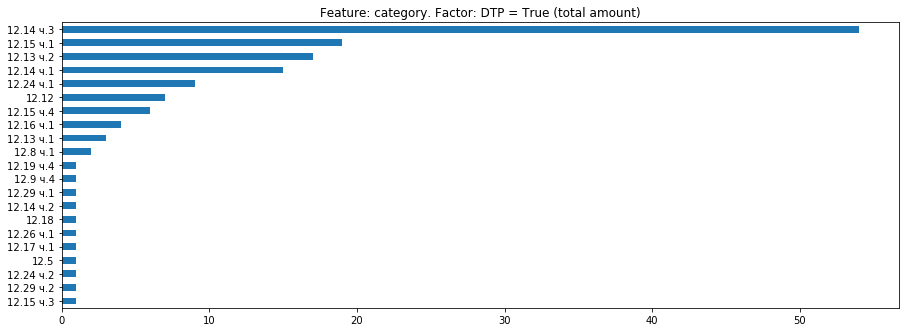

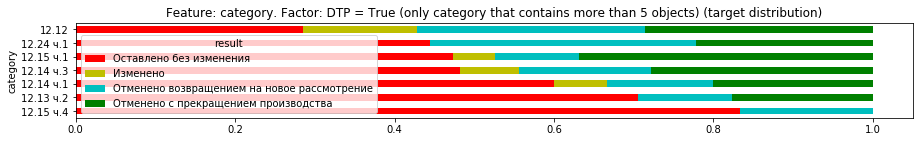

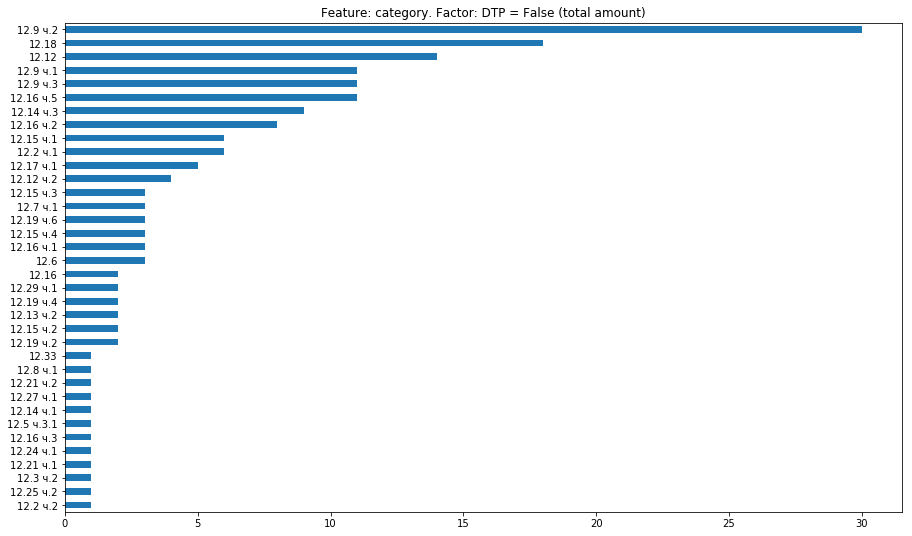

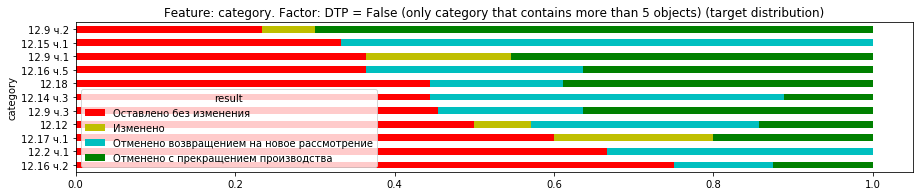

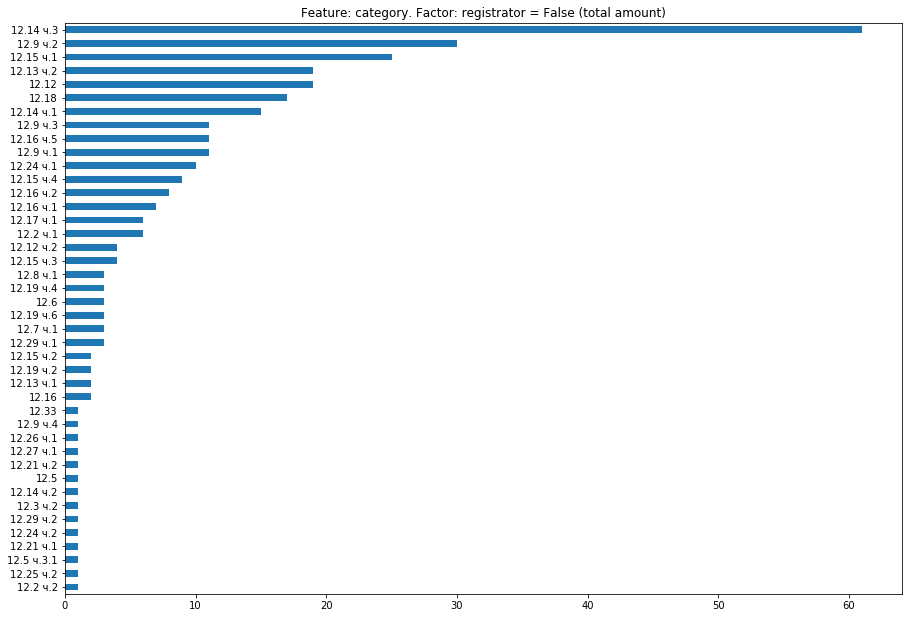

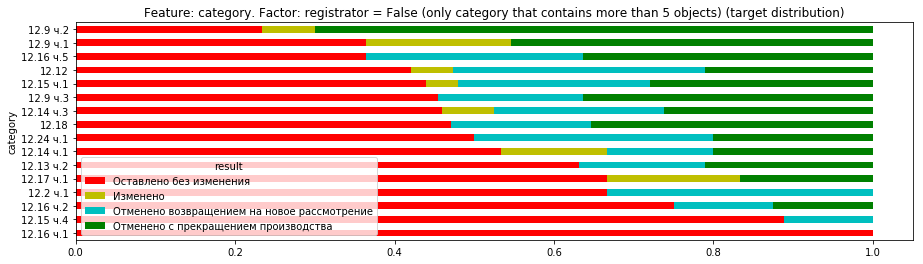

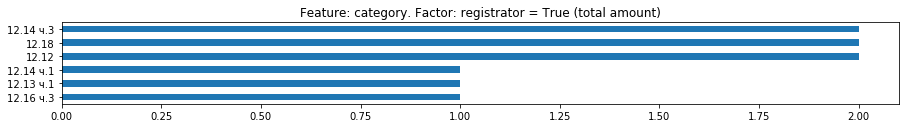

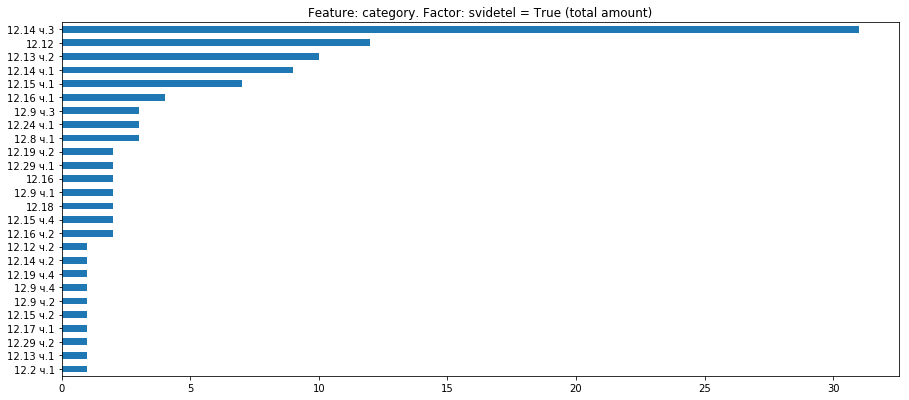

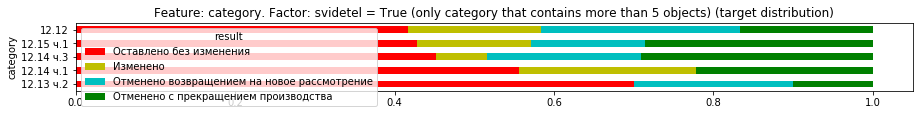

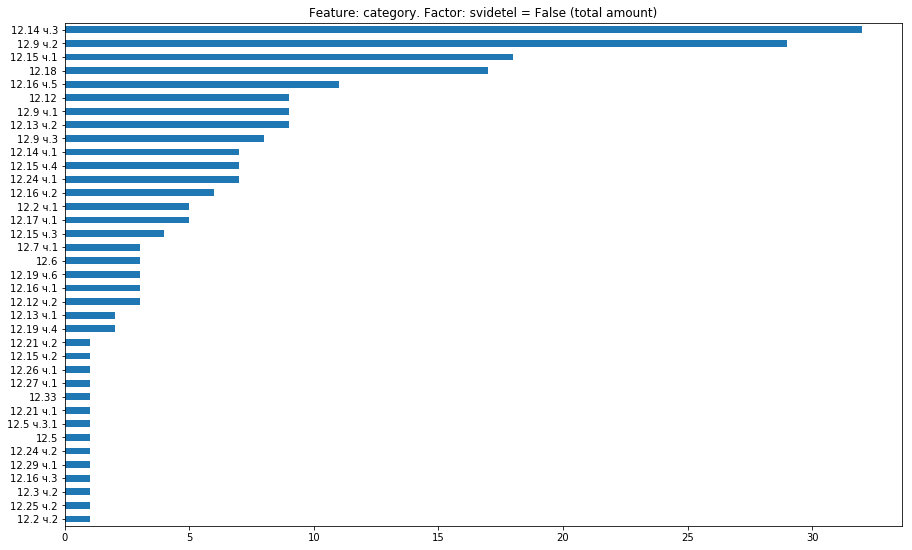

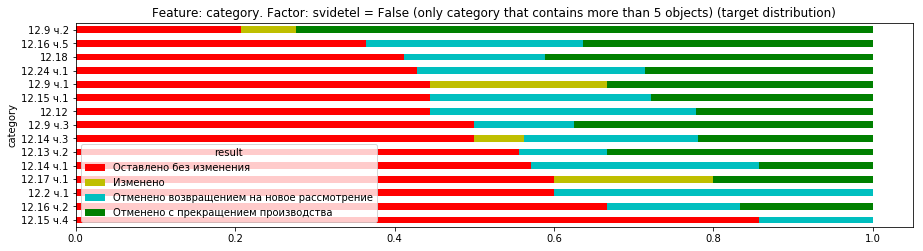

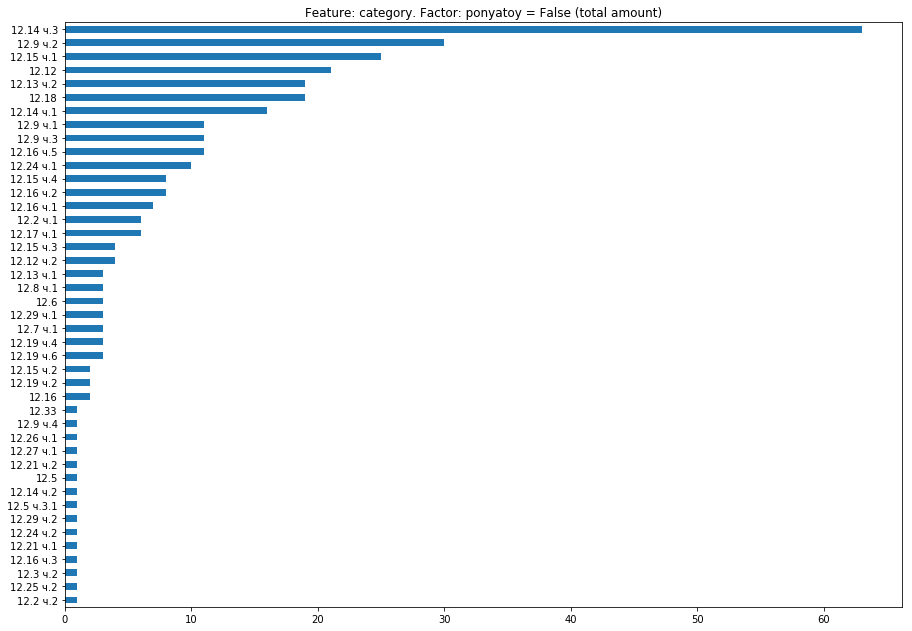

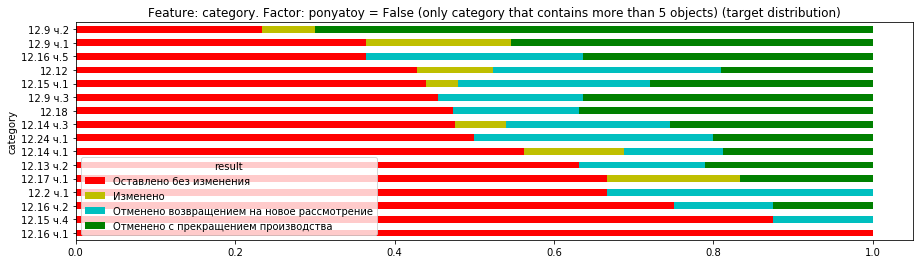

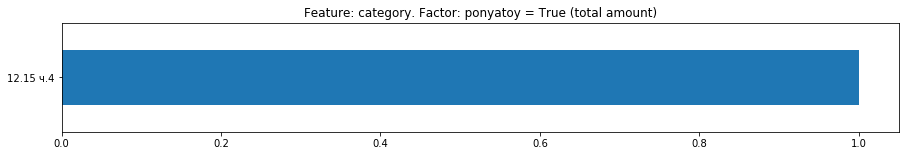

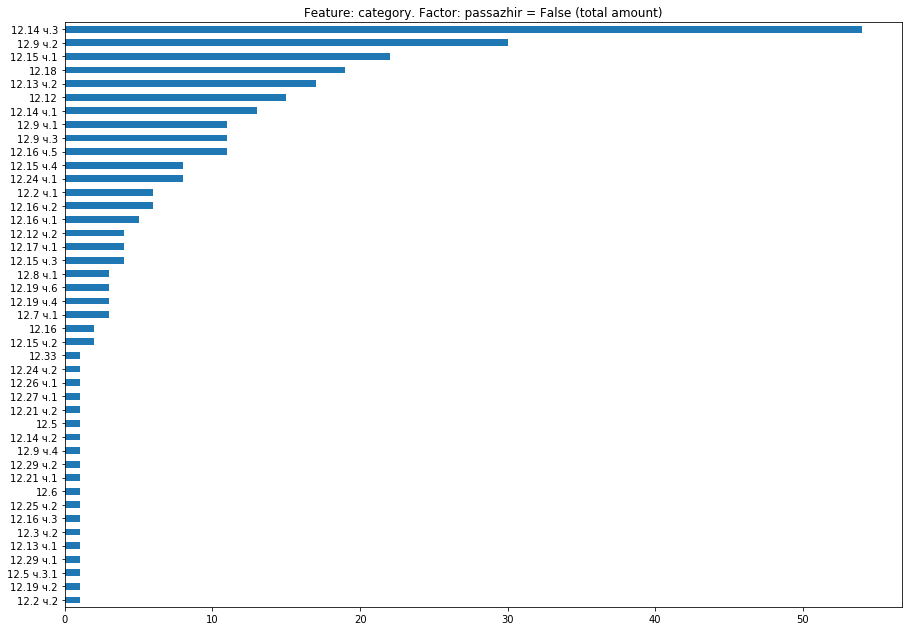

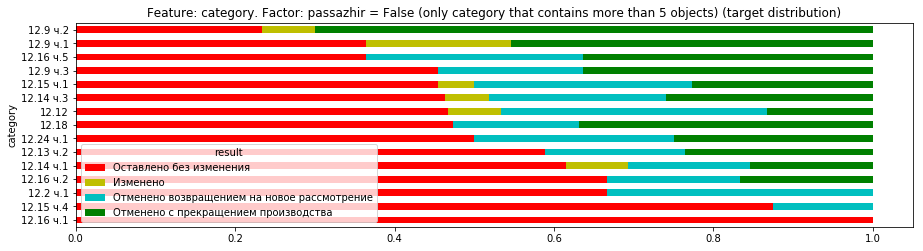

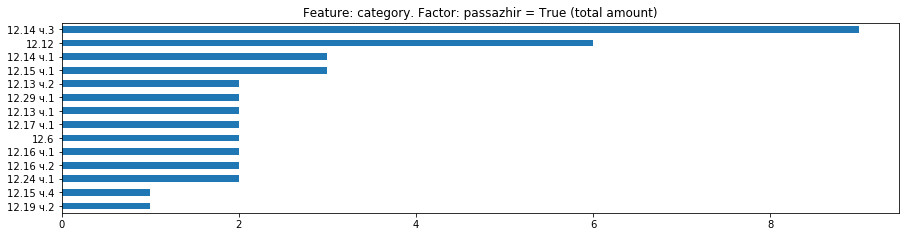

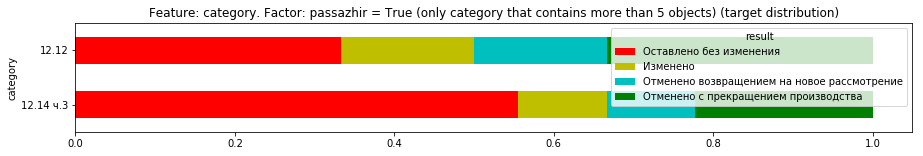

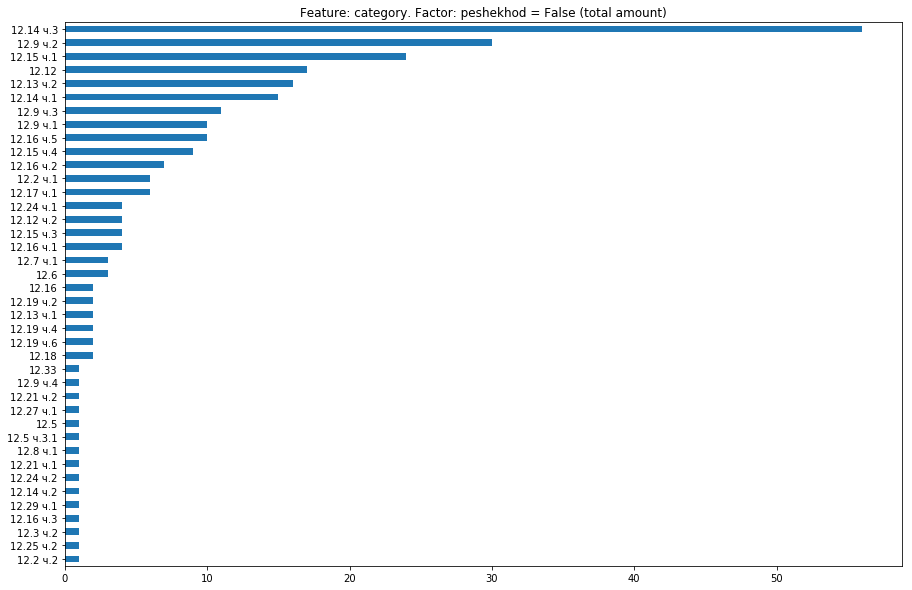

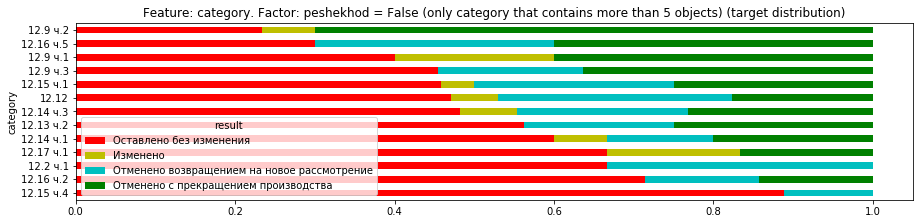

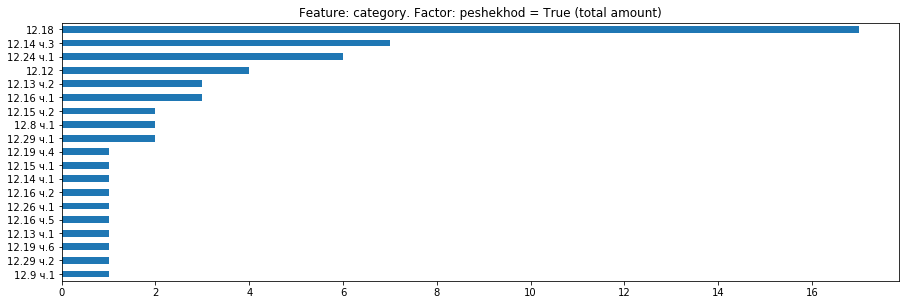

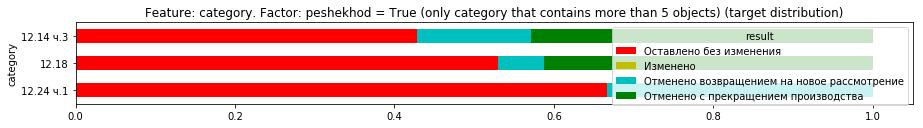

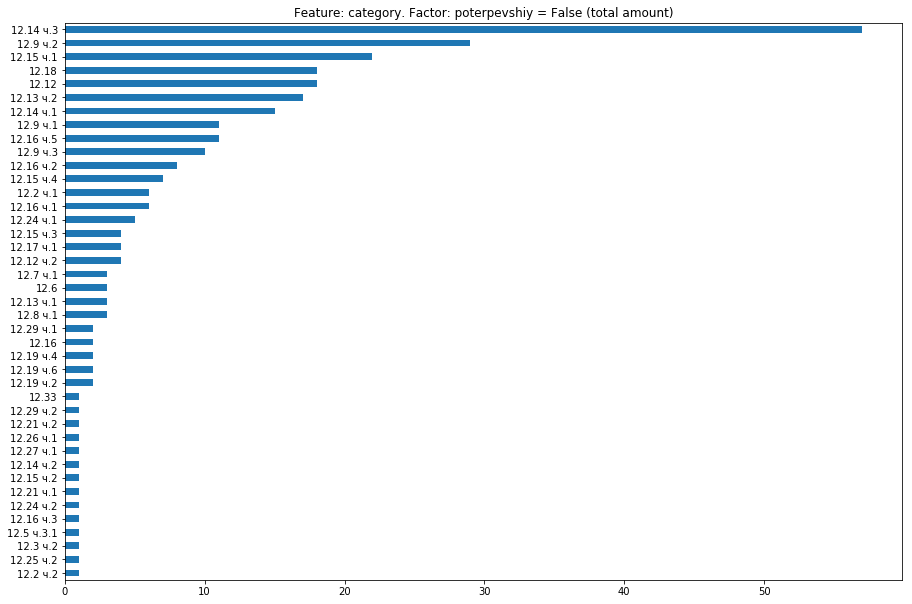

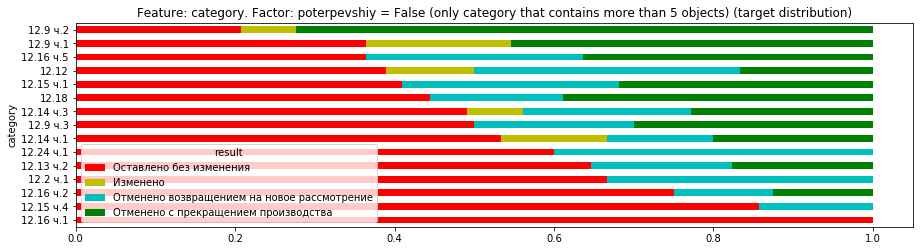

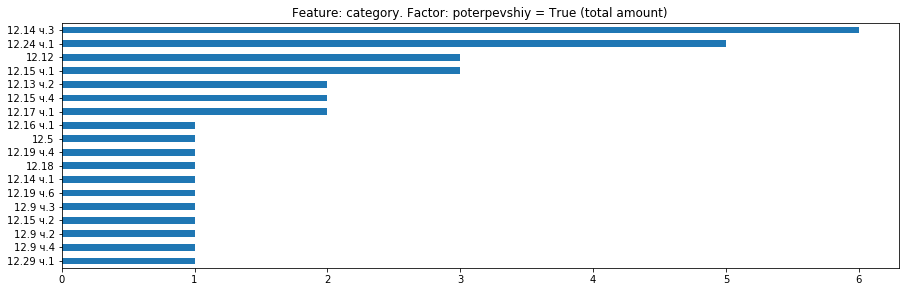

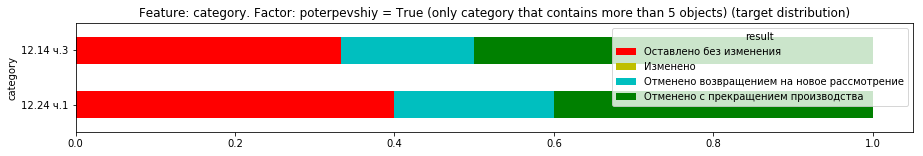

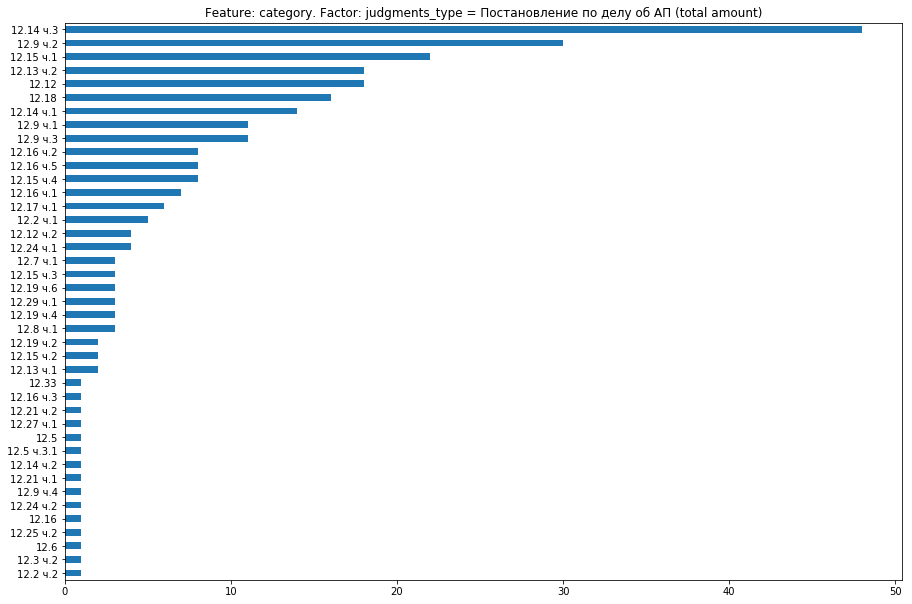

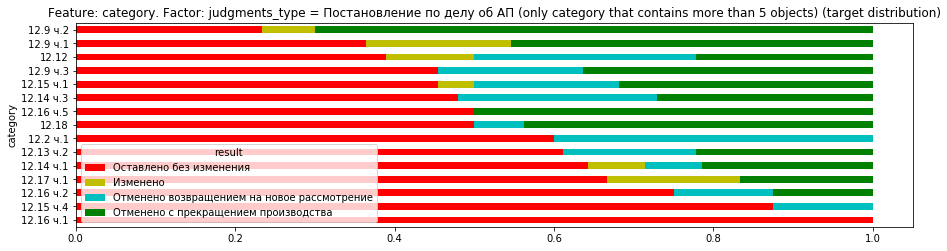

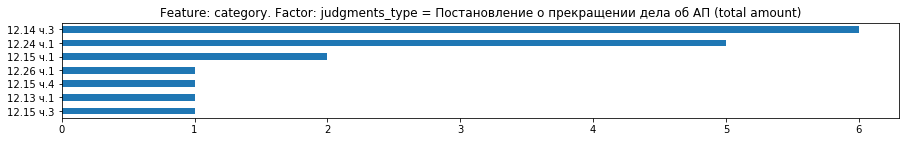

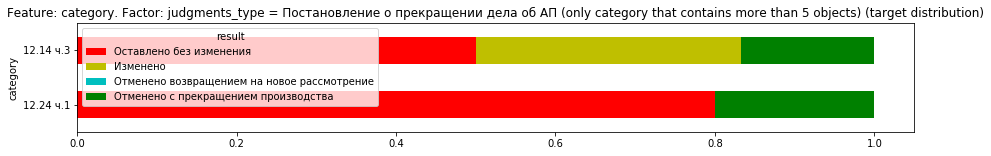

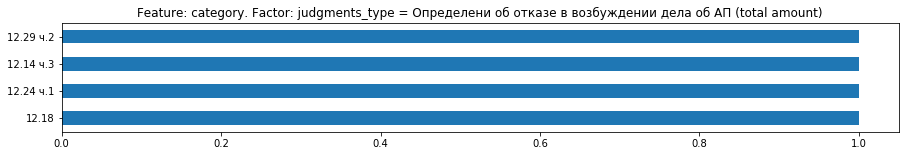

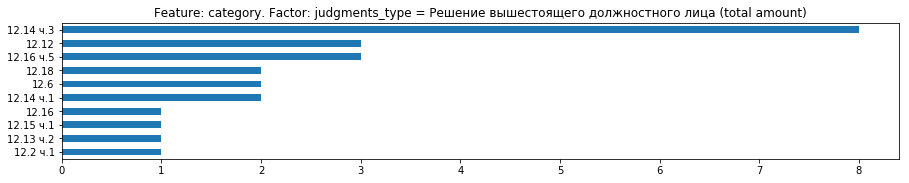

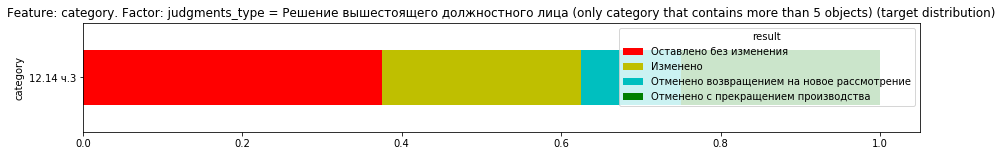

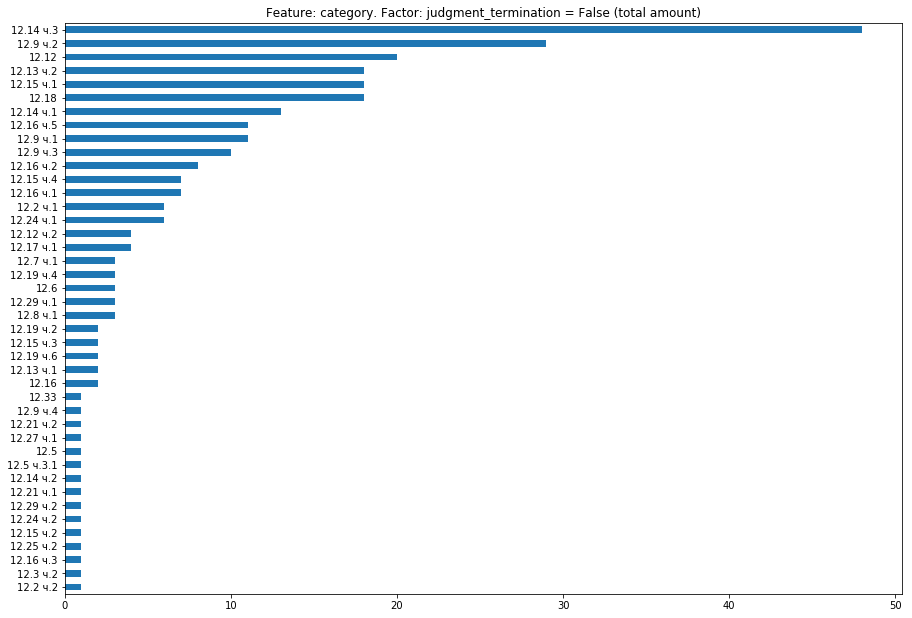

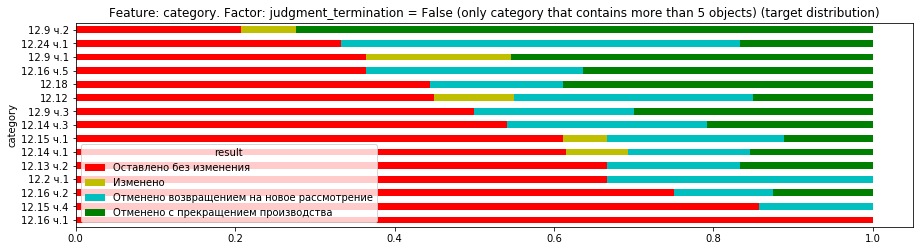

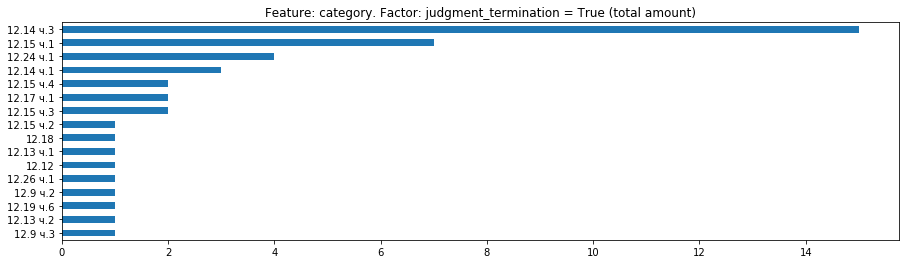

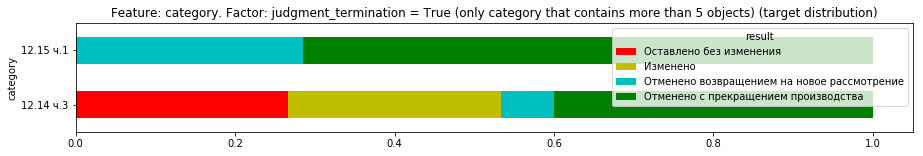

In [8]:
%%time
#plot dist of target by feature 'category' depending on factors

feature='category'
list_factors = ['representative',
 'photo',
 'video',
 'DTP',
 'registrator',
 'svidetel',
 'ponyatoy',
 'passazhir',
 'peshekhod',
 'poterpevshiy',
 'judgments_type',
 'judgment_termination']

for factor in list_factors:
#factor = list_factors[0]
    factor_values = df_gibdd[factor].unique()
    #print(factor)
    for factor_value in factor_values:
    #factor_value = factor_values[0]
        data_filtred = df_gibdd[df_gibdd[factor]==factor_value]
        plot_cat_distr(data_filtred, feature, target='result', title = '. Factor: '+factor+' = '+str(factor_value), 
                   general=True, min_n_objs=5, cm=cm)

#### 1.3.2 Сравнение влияния различных факторов на распределения значений целевой переменной по каждой статье (значению признака 'category')

Цель: выяснить какие факторы больше влияют на соотношение значений целевой переменной в каждой отдедельной статье

Задача: сделать сравнение влияния факторов на соотношение значений целевой переменной в каждой отдельной статье:
1. Отдельный barh plot для каждой статьи
2. В barh plot каждый bar соответсвтует - значению фактора (например DTP=False, representative-True)
3. В каждом bar - соотношение значений целевой переменной

In [9]:
### Здесь будет код

### 1.4 Влияние календарных признаков на соотношение целевой переменной по каждой

#### 1.4.1 Динамика измнения суммарного месячного количества решений каждого класса (уникального значения целевой переменной)

#### 1.4.2 Динамика измнения суммарного годового количества решений каждого класса (уникального значения целевой переменной)

#### 1.4.3 Зависимость количества решений каждого класса по месяцам